<img src="./images/DLI_Header.png">

## Scaling Learning Rate with Batch Size

It's important to recognize that when we scale our training to multiple GPUs, the batch size that we give each GPU is not the overall effective batch size. After each mini-batch is processed and a single GPU performs backpropagation, those weights are averaged among all the ranks. As a result, one update to the model takes into account every mini-batch, accross all the GPUs. The effective batch size is therefore the size of the mini-batch multiplied by the number of GPUs. As a result, when more and more GPUs are used, the effective batch size can get very large.

As you saw in Lab 1, larger batch sizes can lead to drops in accuracy, especially in a network's ability to generalize. The effect of a larger batch size also brings us closer to full batch gradient descent, and takes some of the variance or noise out of the process. Additionally, with a larger batch size fewer update steps are taken per epoch, which can slow down the training.

The common approach to adding variance back into the process, as well as accounting for fewer steps per epoch, is to increase the learning rate as you increase batch size. As the algorithm takes fewer steps per epoch, adjusting the learning rate compensates for this with a larger step each time.

Theory suggests that if we scale batch size by K, we should scale learning rate by the square root of K to maintain the variance. It's also common in large scale training to adjust the learning rate linearly, by a factor of K. 

### Experimentation

For this exercise, take about 15-20 minutes experimenting with different learning rates and batch sizes. Try holding the batch size steady while increasing the learning rate, and then try increasing the batch size while holding the learning rate steady. Finally, as you continue to increase the batch size, increase the learning rate as well. Try batch sizes up to 128 or even 256, and a learning rate up to .08 or higher. We recommend that you pick a certain validation accuracy for the training to reach using `--target-accuracy`, or to simply run the training for 2-3 minutes each time. 

Take a look at the chart regularly to see how training runs compare. Again, feel free to remove datasets from the `training_data` folder if the chart gets too crowded. 

The object of the exercise is not necessarily to find the "optimal" combination, but more to get a feel for the trends as you adjust the parameters. Note that because of the randomness in the process, both in terms of the starting weights, as well as the shuffling of the data, you are not guaranteed to get the same results when you run the same training twice.   

When you feel you have a good understanding of how the training is affected, move on to the next section.

In [1]:
num_gpus = 4

In [2]:
!mpirun -np $num_gpus python fashion_mnist.py --base-lr 0.001 --batch-size 32 --target-accuracy 0.82

2022-01-19 12:57:46.212101: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 12:57:46.212104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 12:57:46.212095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 12:57:46.212102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 12:57:47.733137: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-19 12:57:47.733487: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-19 12:57:47.733609: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-

In [3]:
# The plotting script needs to be defined again, now that you're in a different notebook
%matplotlib widget
import os
import numpy as np
import matplotlib.pyplot as plt

# By default we skip the first row, which contains the headers
# By skipping 2 rows, you can disregard the first data-point (0,0) to get a closer look
def plot_trainings(skiprows=1):
    plt.close()
    for filename in os.listdir("training_data"):
        if filename == ".ipynb_checkpoints": continue
        x, y = np.loadtxt("training_data/" + filename, delimiter=',', unpack=True, skiprows=skiprows)
        plt.plot(x,y, label=filename.split('.csv')[0])

    plt.xlabel('Time (s)')
    plt.ylabel('Validation Accuracy')
    plt.title('Training Comparison')
    plt.legend()
    plt.show()

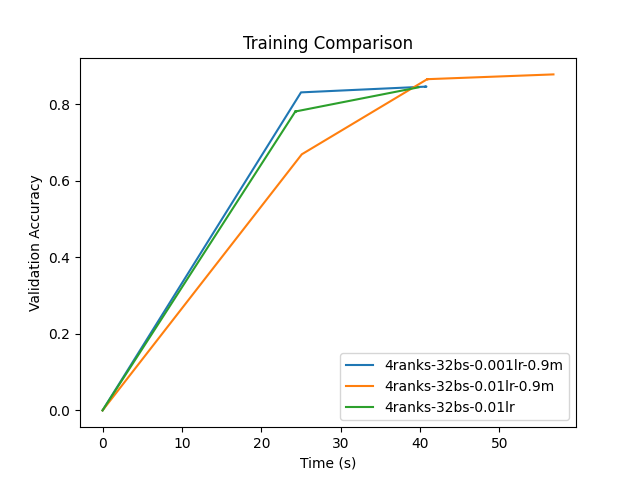

In [4]:
# You can try running plot_trainings(2) to skip the (0,0) datapoint
plot_trainings()

## Adding Learning Rate Warmup

In the course of your experimentation, you might have found that a high enough learning rate caused the network to never converge. You may have seen validation accuracy stay around .10, meaning the model was only as good as guessing at random. If you didn't see this effect yet, run the following training for a couple of epochs. (_Note: the training can "get lucky" and converge. Try running more than once and you should see divergence._)

In [5]:
!mpirun -np $num_gpus python fashion_mnist.py --base-lr .06 --batch-size 32

2022-01-19 13:03:34.364152: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:03:34.364165: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:03:34.364190: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:03:34.378389: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:03:35.910450: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-19 13:03:35.910447: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-19 13:03:35.910981: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-

It is often the case that a high learning rate at the beginning of a training can cause divergence. In this scenario, the weights are updated with a high enough magnitude that they overshoot, and never end up finding the slope toward a minimum. 

In order to remedy this, we will implement a technique known as learning rate warmup. With this approach, the learning rate will start at a fraction of the target value, and slowly scale up over a series of epochs. This allows the network to move slowly at first, taking "careful steps" as it finds a slope toward the minimum. As the learning rate increases to the target value, the benefits of the larger learning rate will take effect.

### Implementation

Horovod has a convenient callback for the Keras API that implements the logic: `horovod.tensorflow.keras.callbacks.LearningRateWarmupCallback`. By default, over the first 5 epochs it will gradually increase, starting from the _learning rate / the number of GPUs_. Execute the next cell to see information on the callback.

In [8]:
import horovod.tensorflow.keras as hvd
?hvd.callbacks.LearningRateWarmupCallback

Init signature:
hvd.callbacks.LearningRateWarmupCallback(
    initial_lr,
    warmup_epochs=5,
    momentum_correction=True,
    steps_per_epoch=None,
    verbose=0,
)
Docstring:     
Implements gradual learning rate warmup:

    `lr = initial_lr / hvd.size()` ---> `lr = initial_lr`

`initial_lr` is the learning rate of the model optimizer at the start of the training.

This technique was described in the paper "Accurate, Large Minibatch SGD: Training
ImageNet in 1 Hour". See https://arxiv.org/pdf/1706.02677.pdf for details.

Math recap:

.. math::

    epoch &= full\_epochs + \frac{batch}{steps\_per\_epoch}

    lr'(epoch) &= \frac{lr}{size} * (\frac{size - 1}{warmup} * epoch + 1)

    lr'(epoch = 0) &= \frac{lr}{size}

    lr'(epoch = warmup) &= lr
Init docstring:
Construct a new LearningRateWarmupCallback that will gradually warm up the learning rate.

Args:
    initial_lr: Initial learning rate at the start of training.
    warmup_epochs: The number of epochs of the warmup phase. D

To implement the callback follow the next steps. 

Step 1: Register a new `warmup-epochs` argument using the following code.

```python
parser.add_argument('--warmup-epochs', type=float, default=5,
                    help='number of warmup epochs')
```

Step 2: Using `args.warmup_epochs` as the `warmup_epochs` argument, implement the callback in the Horovod callbacks array. To get a printout when the warmup is finished, set the `verbose` argument to `verbose`.

Step 3 (optional): Update the CSV filename to include the number of warmup epochs.

If you have trouble, you can find the solution in `solutions/add_lr_warmup.py` 

Once you are finished, try again and see if it looks better.

In [7]:
!mpirun -np $num_gpus python fashion_mnist.py --base-lr .06 --batch-size 32

2022-01-19 13:08:06.802578: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:08:06.802599: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:08:06.802601: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:08:06.802607: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:08:08.340570: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-19 13:08:08.340741: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-19 13:08:08.340863: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-

## Large Scale Optimizations

The Fashion MNIST exercise that we've been running in this course is a fairly small problem for a handful of GPUs. This allows us to run trainings quickly, on the order of minutes, to see interesting results. As problems get bigger, in terms of dataset size and model complexity, larger systems with many more GPUs can be crucial to reduce training times. 

However, as scaling continues, and the batch size and learning rate increase, a problem can arise. When the learning rate is large, the update to the weights may be larger than the weights themselves, causing the training to diverge. 

To approximate a large scale training with a high learning rate, run the next cell. (_Note that the algorithm can "get lucky" and converge, but if you run multiple times, you should see divergence._)

In [ ]:
!mpirun -np $num_gpus python fashion_mnist.py --base-lr .16 --batch-size 256

### The NovoGrad Optimizer

A series of optimizers have been created to address this problem, and allow for scaling to very large batch sizes and learning rates. In this exercise we'll be using the [NovoGrad optimizer](https://arxiv.org/abs/1905.11286). NovoGrad has the standard form of an update to the weights,

\begin{equation*}
  \large
  \Delta \mathbf{w} = -\lambda\, \mathbf{m}
\end{equation*}

but the $\mathbf{m}$ term appropriately normalizes the gradients to avoid the [vanishing gradient (or exploding gradient) problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), using a gradient-averaging scheme similar to how SGD uses momentum to do that normalization. NovoGrad ensures that the learning rate is scaled appropriately on each layer, which empirically is [important in the large batch regime](https://arxiv.org/abs/1708.03888). If you are interested in continuing this exploration after this course, the [LAMB optimizer](https://arxiv.org/abs/1904.00962) is another extremely promising recent method worth exploring, which is very similar to NovoGrad in that it combines both [Adam](https://arxiv.org/abs/1412.6980), a popular variant of SGD, and layer-wise learning rates.

If you want to learn more about the theory behind NovoGrad, you may optionally expand the cell below. Otherwise, feel free to continue on to the exercise.


#### Layer-wise learning rate control

NovoGrad combines several insights about SGD. First, it recognizes that gradient updates should be decoupled from the absolute magnitude of the gradient -- the direction is more important than the size. The magnitude of an update should be of order the magnitude of the weight multiplied by the learning rate, and since the learning rate is sufficiently small, this means that we make relatively small updates as we search for the optimum. Unfortunately, traditional SGD does not enforce this; the update to the weights $\mathbf{w}$ is in the form:

\begin{equation*}
  \large
  \Delta \mathbf{w} = -\lambda\, \mathbf{g}
\end{equation*}

where $\lambda$ is the learning rate and $\mathbf{g}$ is the gradient of the loss function. The size of the gradient is determined by the loss function, which is not required to be commensurate with the scale of the weight. Furthermore, backpropagation tends to exacerbate this issue (i.e. the [vanishing gradient (or exploding gradient) problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) that plagued deep CNNs until algorithmic improvements like [residual connections](https://arxiv.org/abs/1512.03385) were developed). Most SGD algorithms developed over the past few years attempt to solve this problem in one way or another.

An intuitive way to deal with this is simply to divide the gradients on each layer by the norm of the gradients of that layer:

\begin{equation*}
  \large
  \Delta \mathbf{w} = -\lambda\, \frac{\mathbf{g}}{|\mathbf{g}|}
\end{equation*}

where the norm $|\mathbf{g}|$ is typically the root-mean-square operation. This can generally be described as [stochastic normalized gradient descent](https://arxiv.org/abs/1507.02030).

Another way to think about this is that, in a sense, the update has the wrong units (see Section 3.2 in the [ADADELTA paper](https://arxiv.org/abs/1212.5701) for a more rigorous discussion than this one). That is, if we imagine that the weights have a dimension (say, meters) and we take the partial derivative with respect to time, then the gradient has units of meters per second (that is, a speed or velocity), and applying an update to a position by adding a velocity does not make sense. We need to update the distance by an amount in meters. Dividing by the gradient by a norm makes the update dimensionless, and we can recover the correct scale by scaling the update by the norm of the weights. That is, we could have an update of the form

\begin{equation*}
  \large
  \Delta \mathbf{w} = -\lambda\, |\mathbf{w}| \frac{\mathbf{g}}{|\mathbf{g}|}
\end{equation*}

which has the desired scale and units, but still points in the direction of the gradient of the loss function.

Both of these approaches largely prevent vanishing/exploding gradients from causing the optimization process to diverge, because the magnitude of the update is now uncoupled from the absolute scale of the gradient, which could be much larger or much smaller than the weights on that layer.

The second approach was taken with the [LARS optimizer](https://arxiv.org/abs/1708.03888), which defines the update on a given layer as:

\begin{equation*}
  \large
  \Delta \mathbf{w} = -\lambda^{\mathrm{global}}\, \lambda^{\mathrm{local}}\, \mathbf{g}
\end{equation*}

where the "global" learning rate is the normal learning rate policy you're familiar with (some small number like 0.01 that may decay over time), and the "local" per-layer learning rate is defined as

\begin{equation*}
  \large
  \lambda^{\mathrm{local}} = \eta\, \frac{|\mathbf{w}|}{|\mathbf{g}|}
\end{equation*}

Here $\eta$ is a "trust coefficient" which should be less than 1 and decides how much we want to update the weights on each layer during an update. Observe that this scheme is essentially equivalent to previous formulation. LARS and related methods have been influential in making possible large-batch SGD.

Note that LARS is very closedly related to [LARC (Layer-wise Adaptive Rate Control)](https://nvidia.github.io/OpenSeq2Seq/html/optimizers.html) and the two terms are sometimes used interchangeably. LARC is a slight variant on LARS that "clips" the local learning rate so that it is not higher than the global learning rate; that is, the update is in the form

\begin{equation*}
  \large
  \Delta \mathbf{w} = -\lambda\, \mathbf{g}
\end{equation*}

with the learning rate set by

\begin{equation*}
  \large
  \lambda = \mathrm{min}(\lambda^{\mathrm{global}}, \lambda^{\mathrm{local}})
\end{equation*}

As a side note, in this discussion we are neglecting [weight decay](https://papers.nips.cc/paper/563-a-simple-weight-decay-can-improve-generalization.pdf) for simplicity, but it is straightforward to add it to these optimizers.

#### Gradient averaging and momentum

A separate set of efforts uses the concept of gradient averaging: the gradient we apply should be an average of the gradient in this step and the gradient in the previous step. As an illustration, we have already discussed how momentum can be used to avoid being trapped in local minima and to more efficiently escape saddle points. SGD with momentum can in fact be seen as a form of gradient averaging -- the effective gradient is a linear combination of the gradient in this step and the gradient from the last step. Optimizers such as [RMSprop](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) implement this idea; the update looks a lot like the LARS update, except that the norm of the gradient used in the denominator is a linear combination of the gradient from this step and the gradient from the last step. 

The most popular implementation of this concept is the [Adam](https://arxiv.org/abs/1412.6980) optimizer, which works as follows. Suppose we have an update in this form:

\begin{equation*}
  \large
  \Delta \mathbf{w} = -\lambda\, \frac{\mathbf{m}}{\sqrt{v}}
\end{equation*}

where $\mathbf{m}$ is a gradient-like term and $v$ is a term that is like the norm of the square of the gradient (so that we recover the earlier form if $\mathbf{m} = \mathbf{g}$ and $v = |\mathbf{g}^2|$). We can implement gradient averaging in the following way:

\begin{equation*}
  \large
  \mathbf{m} = \beta_{1}\, \mathbf{m}_{\mathrm{prev}} + (1 - \beta_{1})\, \mathbf{g}
\end{equation*}

where $\mathbf{m}_{\mathrm{prev}}$ was the "gradient" term on the previous step, and

\begin{equation*}
  \large
  v = \beta_{2}\, v_{\mathrm{prev}} + (1 - \beta_{2})\, |\mathbf{g}^2|
\end{equation*}

where $v_{\mathrm{prev}}$ was the "gradient-squared" term on the previous step. This means that we are keeping a running average of the gradient, rather than simply applying the gradient from this step. Adam is thus quite robust as a training optimizer compared to simpler optimizers like traditional SGD; however, it also tends to [generalize worse](https://arxiv.org/abs/1712.07628) than SGD with momentum.

#### Combining layer-wise rate control and gradient averaging

NovoGrad combines both of these concepts. The form of the update is back to

\begin{equation*}
  \large
  \Delta \mathbf{w} = -\lambda\, \mathbf{m}
\end{equation*}

but the $\mathbf{m}$ term appropriately normalizes the gradients:

\begin{equation*}
  \large
  \mathbf{m} = \beta_{1}\, \mathbf{m}_{\mathrm{prev}} + (1 - \beta_{1})\, \frac{\mathbf{g}}{\sqrt{v}}
\end{equation*}

(and we calculate the update to $v$ first so that we can use it in the update to $\mathbf{m}$).

### NovoGrad Implementation

Your next step will be to replace the SGD optimizer in `fashion_mnist.py` with the NovoGrad optimizer. 

Step 1: Import the NovoGrad optimizer:
```python
from tensorflow_addons.optimizers import NovoGrad
```
This is helpfully provided for us by the [TensorFlow Addons](https://github.com/tensorflow/addons) repository.

Step 2: Replace the SGD optimizer with NovoGrad:
```python
opt = NovoGrad(lr=args.base_lr, grad_averaging=True)
```
The `grad_averaging` parameter, which weights the momentum using a mix of the current and previous steps (like Adam), is empirically helpful for this problem.

If you have any trouble, you can find the solution at `solutions/add_novograd.py`. Once you've implemented the optimizer, run the training again in the cell below.

In [9]:
!mpirun -np $num_gpus python fashion_mnist.py --base-lr .16 --batch-size 256

2022-01-19 13:48:34.468073: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:48:34.468070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:48:34.468068: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:48:34.468077: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-19 13:48:36.002948: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-19 13:48:36.003130: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-19 13:48:36.003355: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-

### Results

Hopefully the training converged for you more successfully than with standard stochastic gradient descent on the training dataset. Validation accuracy is probably poor in the early epochs, but after waiting for at least 10-20 epochs, you will likely see validation accuracy start to steadily improve and eventually converge to a desirable result. NovoGrad, as well as the other optimizers that are available are important tools to consider when you build your training pipeline. 

## Conclusion and Next Steps

Multiple GPU training is quickly becoming a critical tool for engineers and data scientists. Accelerated training has made previously impossible AI challenges, such as complex image classification, solveable. Similarly, we have made amazing strides in natural language processing with the [BERT](https://arxiv.org/abs/1810.04805) model, which is often trained on dozens to hundreds of GPUs. But multi GPU training has the power to transform deep learning work at all levels, not just for high-end production implementations. If your training takes hours or even days, experimentation can become tedious and even impractical. Using multiple GPUs to speed up training allows for more time to be spent on refining and improving your model. It enables you to be more flexible and responsive, both in the initial phases of development and as you update and improve your model over time.

Moving forward, you may have access to a multi GPU system such as an appliance based on the [HGX architecture](https://www.nvidia.com/en-us/data-center/hgx/), or plan to use a cloud server, such as the one provided for this course. In either case, the [NGC Catalog](https://www.nvidia.com/en-us/gpu-cloud/#ngc-platforms) gives you free access to performance-optimized AI software that provide DL frameworks, pre-trained models, and industry-focused end-to-end AI workflows. We use NGC containers in this course. In addition to removing the challenge associated with installing these frameworks, NGC containers are highly optimized for both training and inference on NVIDIA GPUs. Here’s the guide to [getting started with NGC](https://ngc.nvidia.com/catalog/collections/nvidia:gettingstarted); you can find the most up-to-date documentation in the [NVIDIA docs](https://docs.nvidia.com/ngc/index.html), along with specific setup steps for [Azure](https://docs.nvidia.com/ngc/ngc-azure-setup-guide/index.html), [AWS](https://docs.nvidia.com/ngc/ngc-aws-setup-guide/index.html), and [GCP](https://docs.nvidia.com/ngc/index.html#ngc-with-google-cloud-platform-(gcp). NGC containers are also set up to work right out of the box on dense GPU platforms for AI and computing.

Thank you for joining us in the course today. We hope you feel prepared and excited to apply multi GPU training to your next AI challenge. 

<img src="./images/DLI_Header.png">